In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python3 -c "import torch; print(torch.__version__)"

1.13.1+cu116


In [ ]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [ ]:
class BaseGNNLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1  
        self.w_self = -2 * lim * torch.rand(input_dim, output_dim) + lim
        self.w_neigh = -2 * lim * torch.rand(input_dim, output_dim) + lim
        self.w_readout = -2 * lim * torch.rand(input_dim, output_dim) + lim

    def forward(self, node_feats, adj_matrix):
        node_feats_self = torch.mm(node_feats, self.w_self) 
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh)
        node_feats_readout = torch.mm(torch.mm(torch.ones(len(adj_matrix), len(adj_matrix)),
                                           node_feats), self.w_readout)
        next_node_feats = node_feats_self + \
                        node_feats_neigh + \
                        node_feats_readout
        return next_node_feats

In [ ]:
threshold=50
def act_fn(x):
    #return torch.clamp(x, min=-threshold, max=threshold)
    return torch.relu(x)

In [ ]:
class BaseGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([BaseGNNLayer(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(BaseGNNLayer(hidden_dim, hidden_dim))
        self.layers.append(BaseGNNLayer(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [ ]:
class MLPModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [ ]:
csv = []

for d in [5]:
    for r in [0.5]:
        for num_layers in [2]:
            for mpnn_idx in range(1):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                base_gnn_gr = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)
                
                torch.save(base_gnn_gr,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_gr_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(1):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        print(base_gnn_gr(initial_node_feats, adj_matrix)[:10])
                        output = base_gnn_gr(initial_node_feats, adj_matrix).mean(axis=0)
                        print(output)
                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


tensor([[  0.0000,   0.0000,  63.9645,   0.0000, 127.2070],
        [  0.0000,   0.0000,  55.4118,   0.0000, 121.6497],
        [  0.0000,   0.0000,  72.9468,   0.0000, 133.3528],
        [  0.0000,   0.0000,  73.5412,   0.0000, 132.9523],
        [  0.0000,   0.0000,  64.1476,   0.0000, 126.8048],
        [  0.0000,   0.0000,  64.8892,   0.0000, 128.2473],
        [  0.0000,   0.0000,  89.1166,   0.8683, 144.1325],
        [  0.0000,   0.0000,  89.5421,   0.0000, 143.9208],
        [  0.0000,   0.0000,  63.5701,   0.0000, 127.4654],
        [  0.0000,   0.0000,  70.9003,   0.0000, 132.9997]])
tensor([0.0000e+00, 0.0000e+00, 7.0803e+01, 8.6832e-02, 1.3187e+02])
tensor([[   0.0000,    0.0000, 1979.4666,    0.0000, 3631.9812],
        [   0.0000,    0.0000, 1982.2271,    0.0000, 3633.0796],
        [   0.0000,    0.0000, 2119.0427,    0.0000, 3727.4321],
        [   0.0000,    0.0000, 2394.6797,    0.0000, 3909.8184],
        [   0.0000,    0.0000, 2077.4390,    0.0000, 3694.7837],
     

In [ ]:
import matplotlib.pyplot as plt
import pickle

In [ ]:

#generate 3 images
csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [ ]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_1.pickle"
with open(path_1, 'wb') as handle:
    pickle.dump(csv_numLayer_1,handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_2.pickle"
with open(path_2, 'wb') as handle:
    pickle.dump(csv_numLayer_2,handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_3.pickle"
with open(path_3, 'wb') as handle:
    pickle.dump(csv_numLayer_3,handle)

In [ ]:
plt.rcParams['figure.dpi'] = 600

In [ ]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000]
#x = [10, 50, 100]

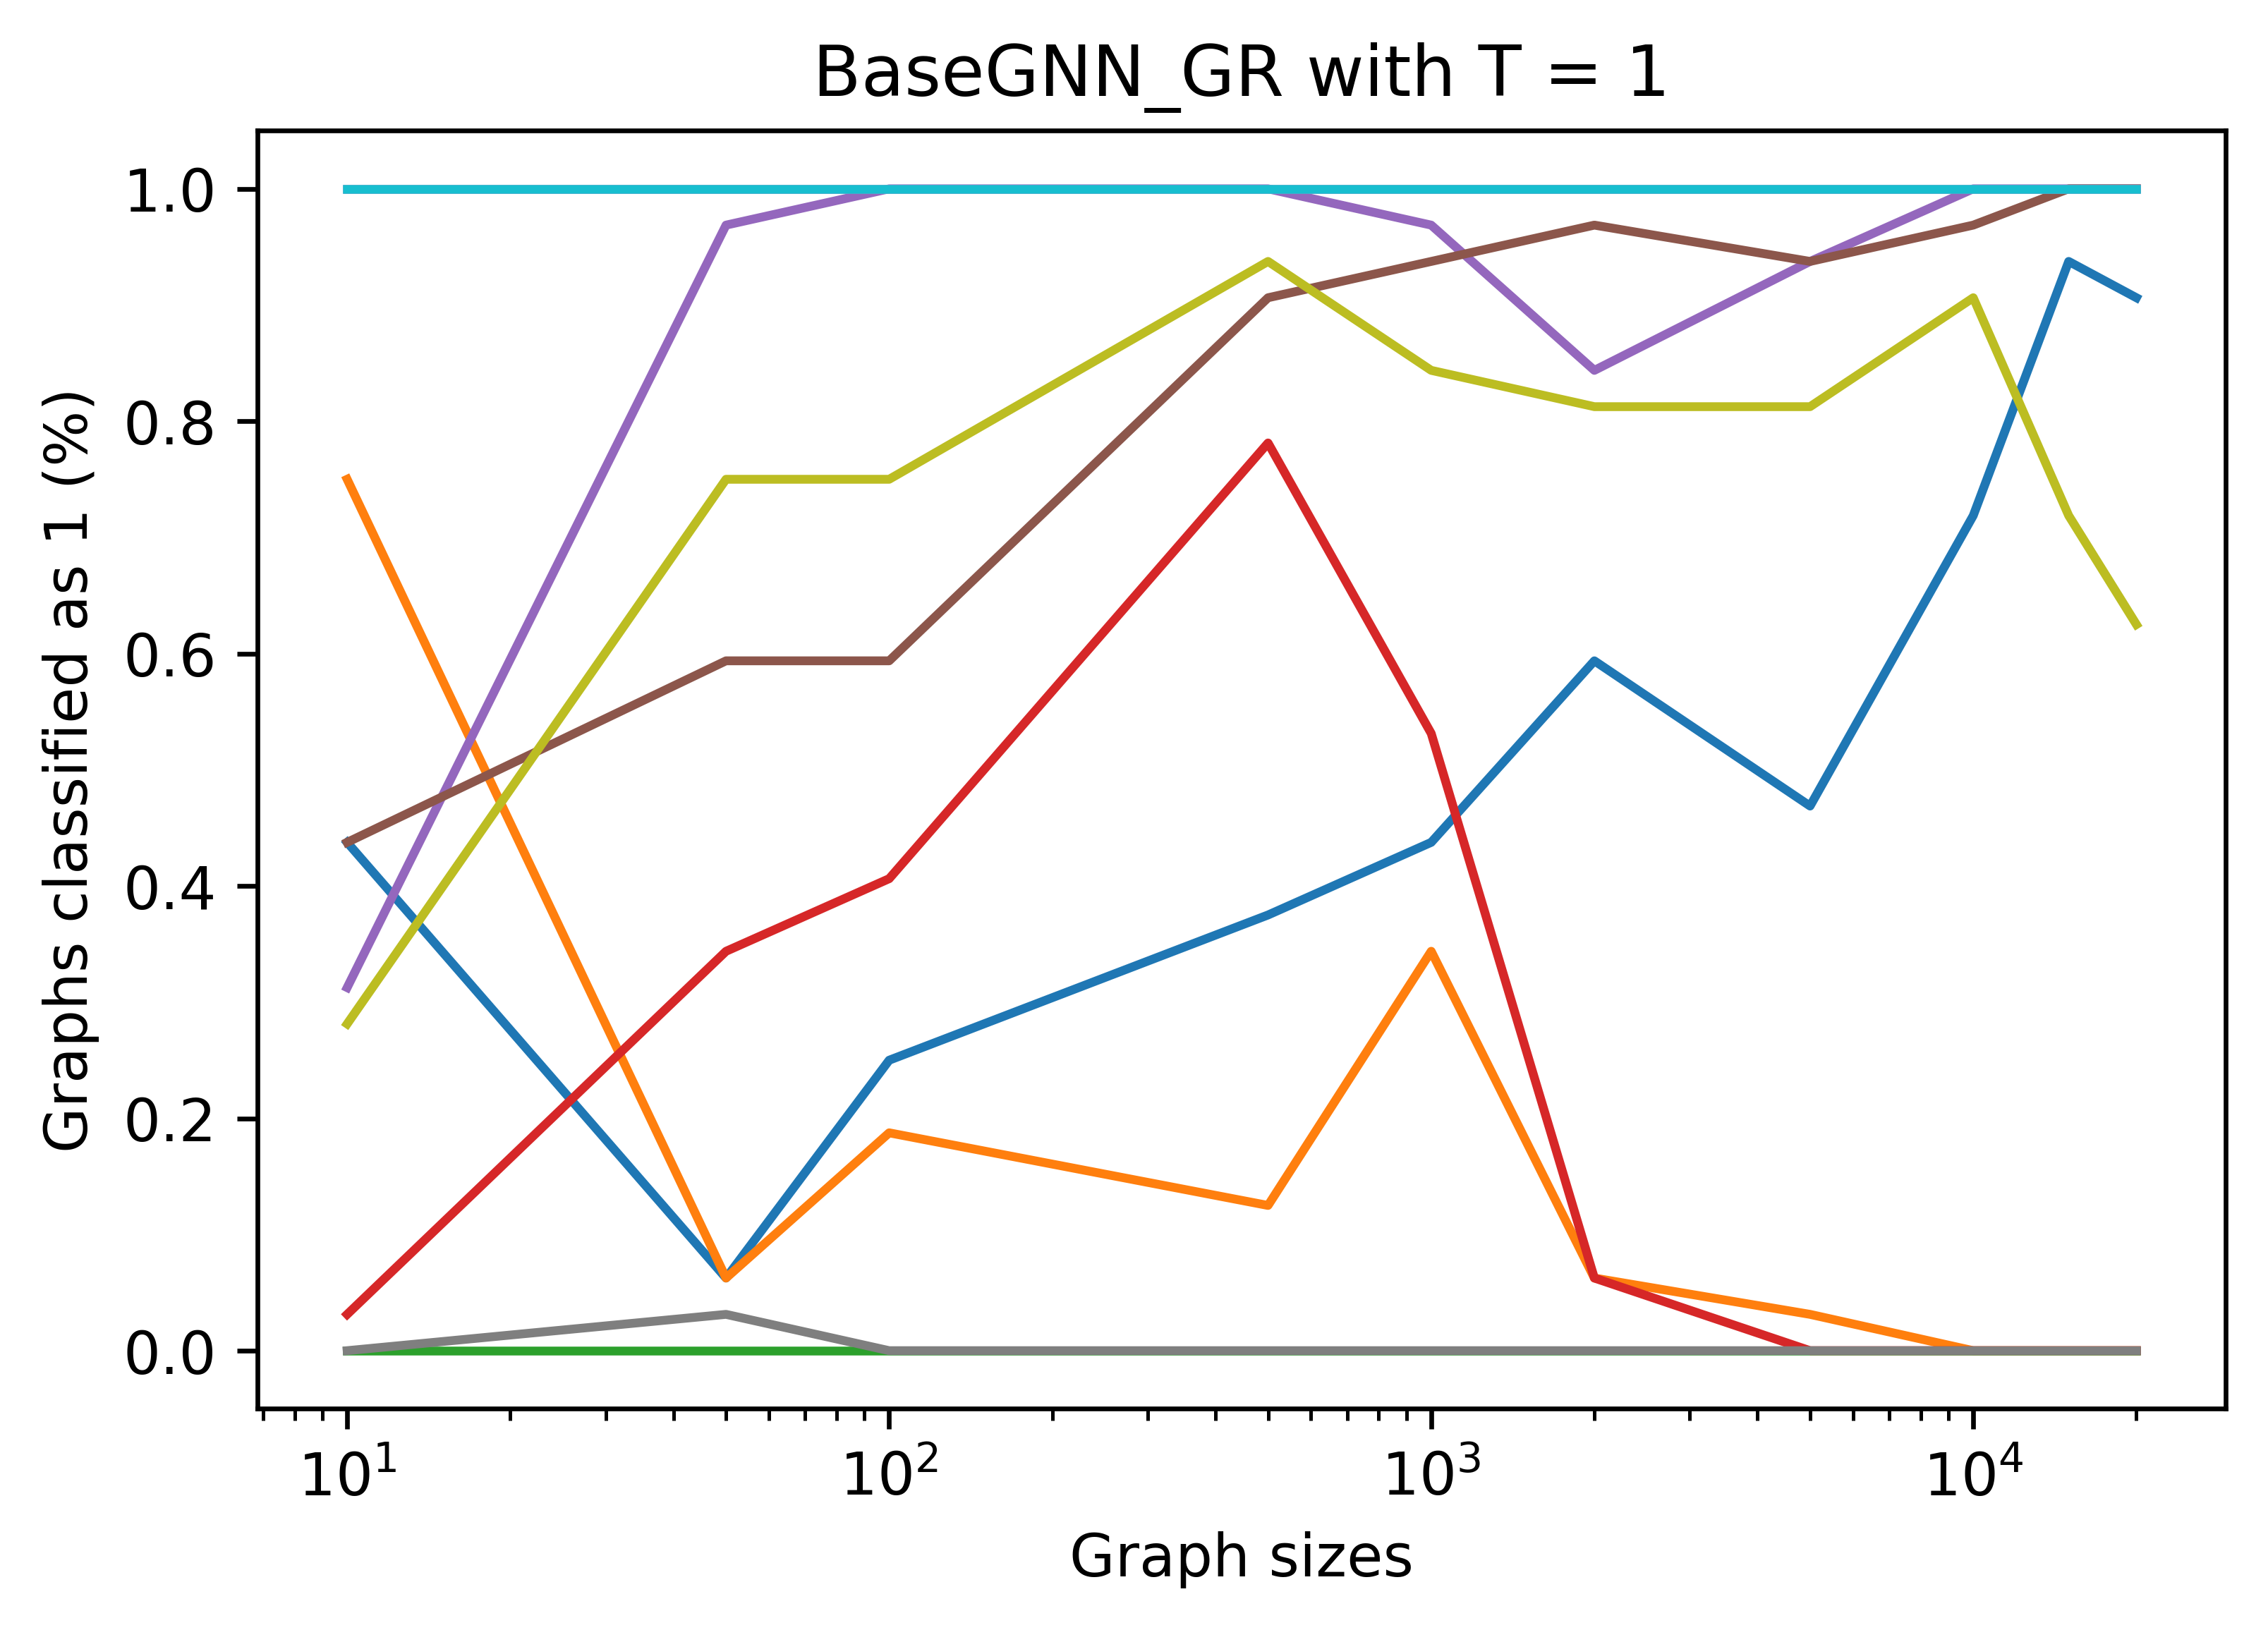

In [ ]:
for y in csv_numLayer_1:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/BaseGNN_GR with T = 1')
plt.show()

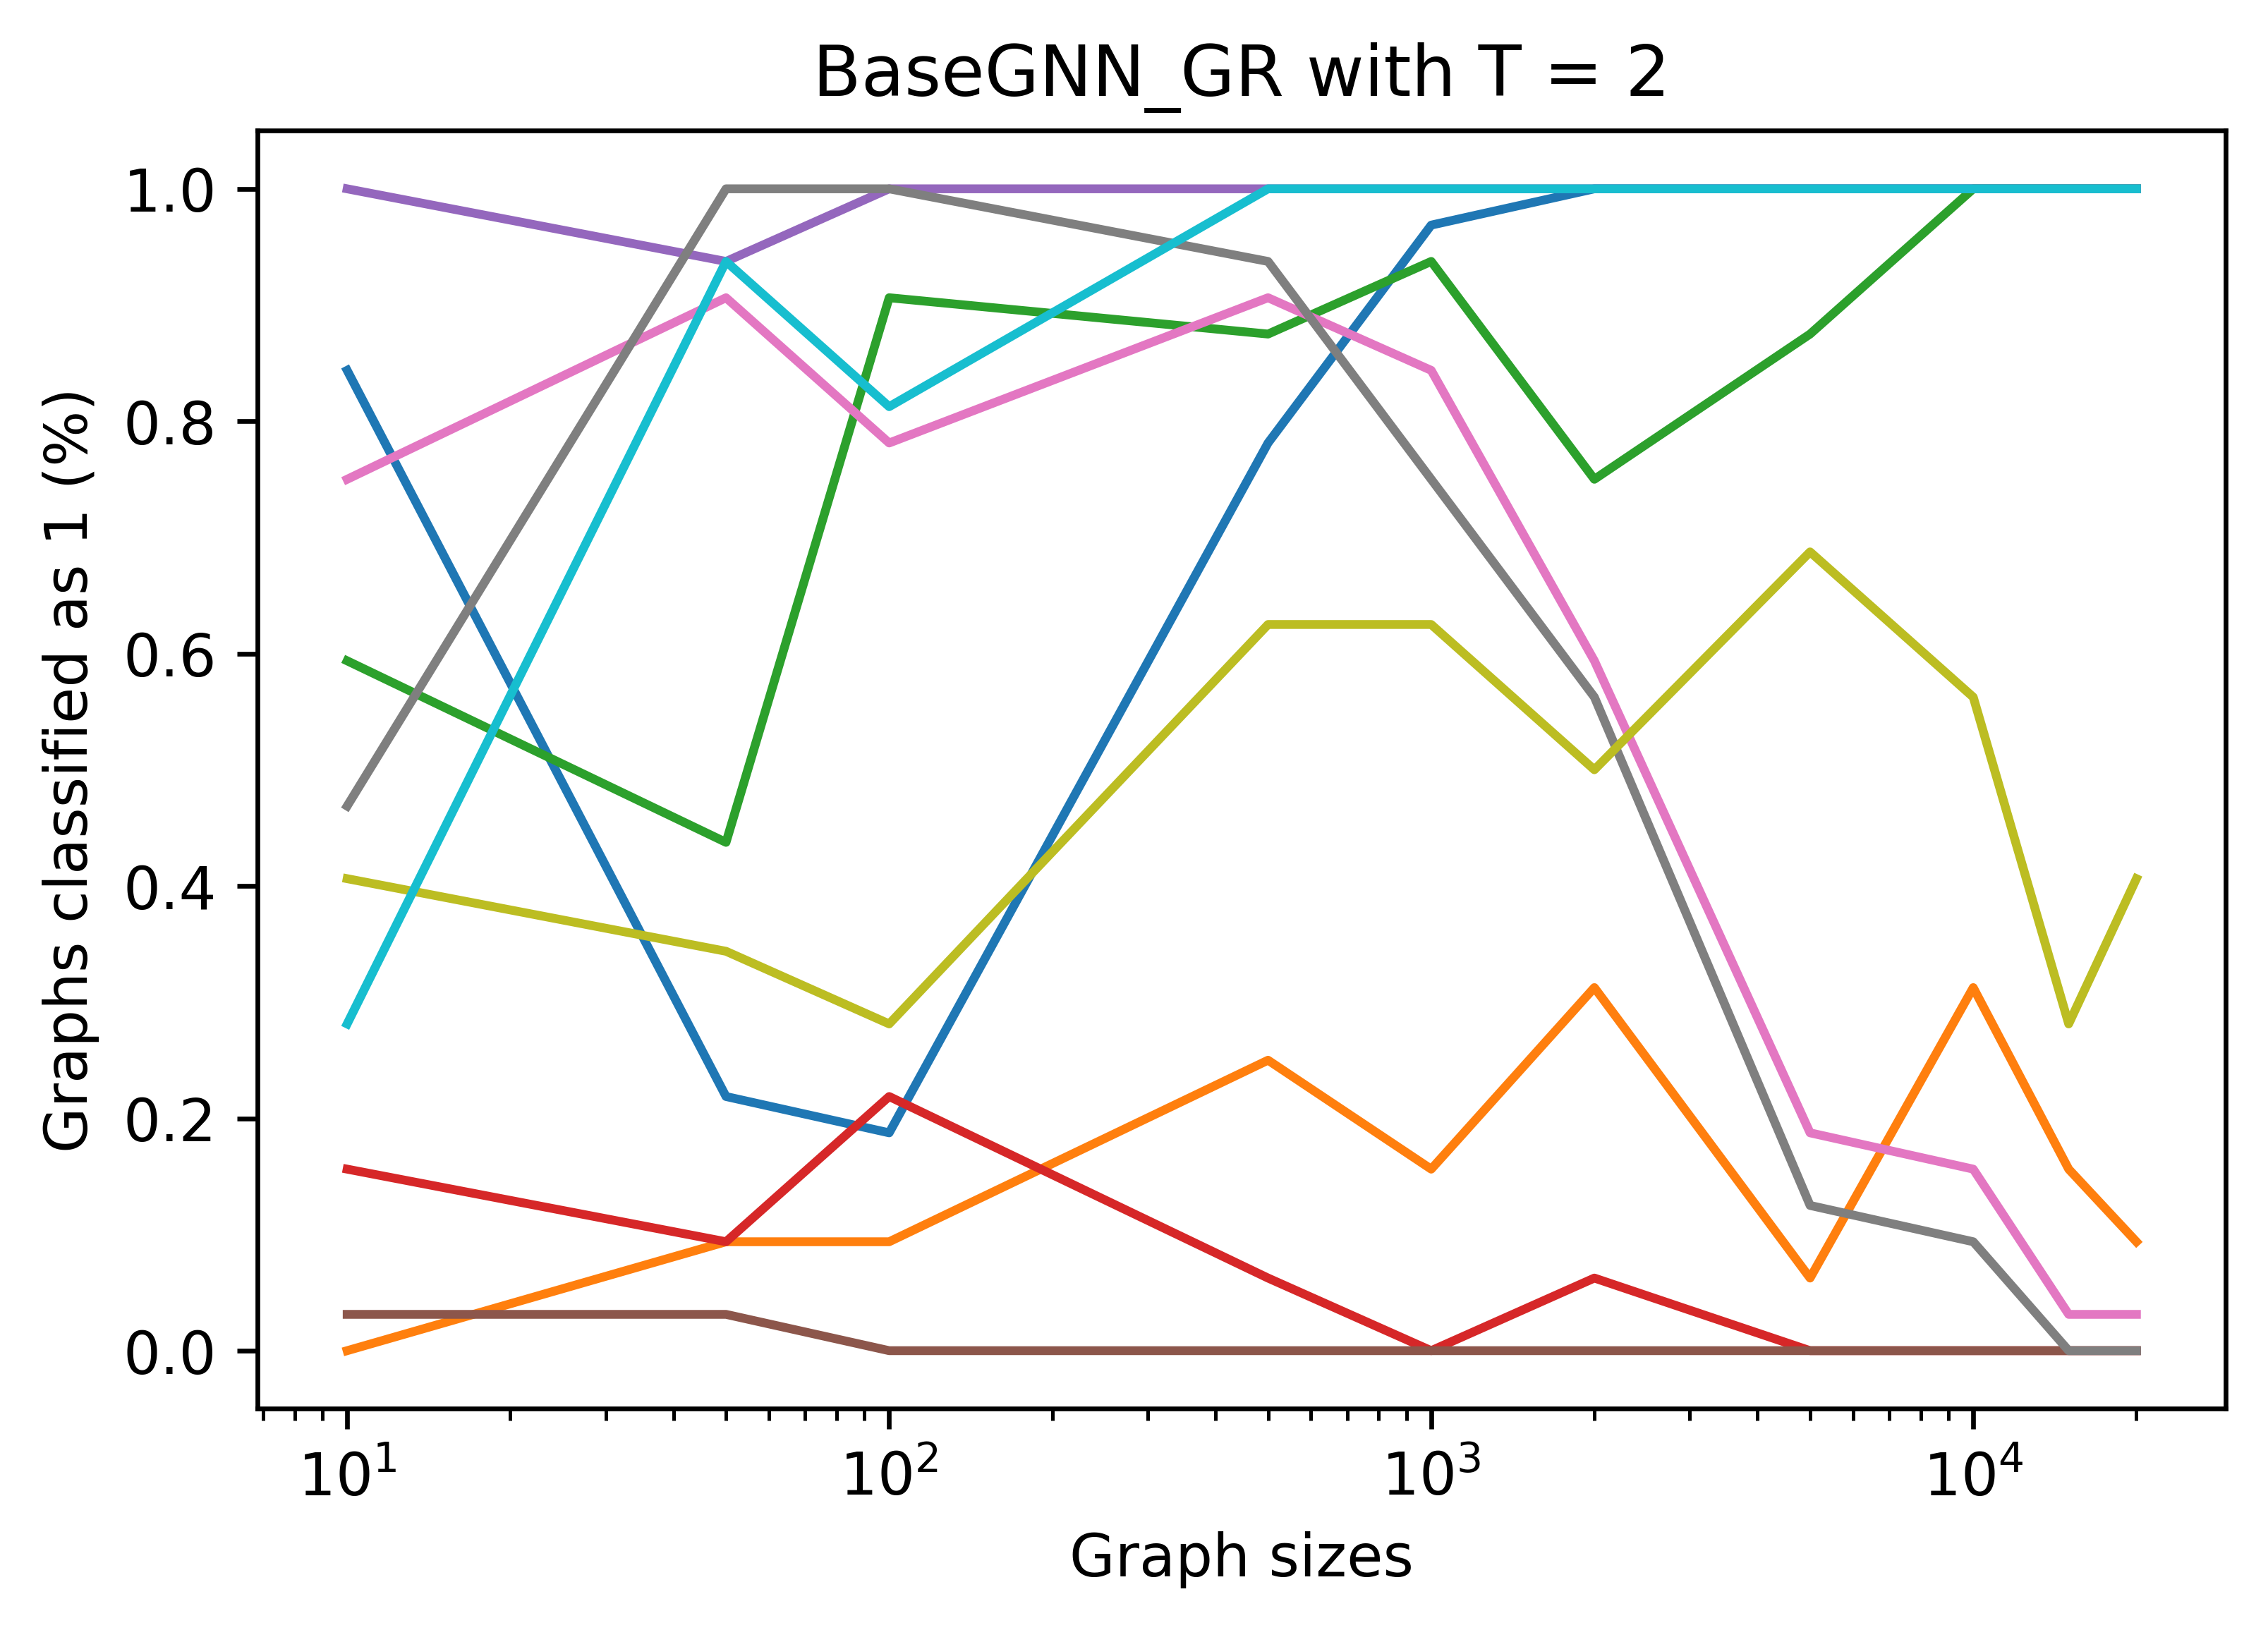

In [ ]:
for y in csv_numLayer_2:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/BaseGNN_GR with T = 2')
plt.show()

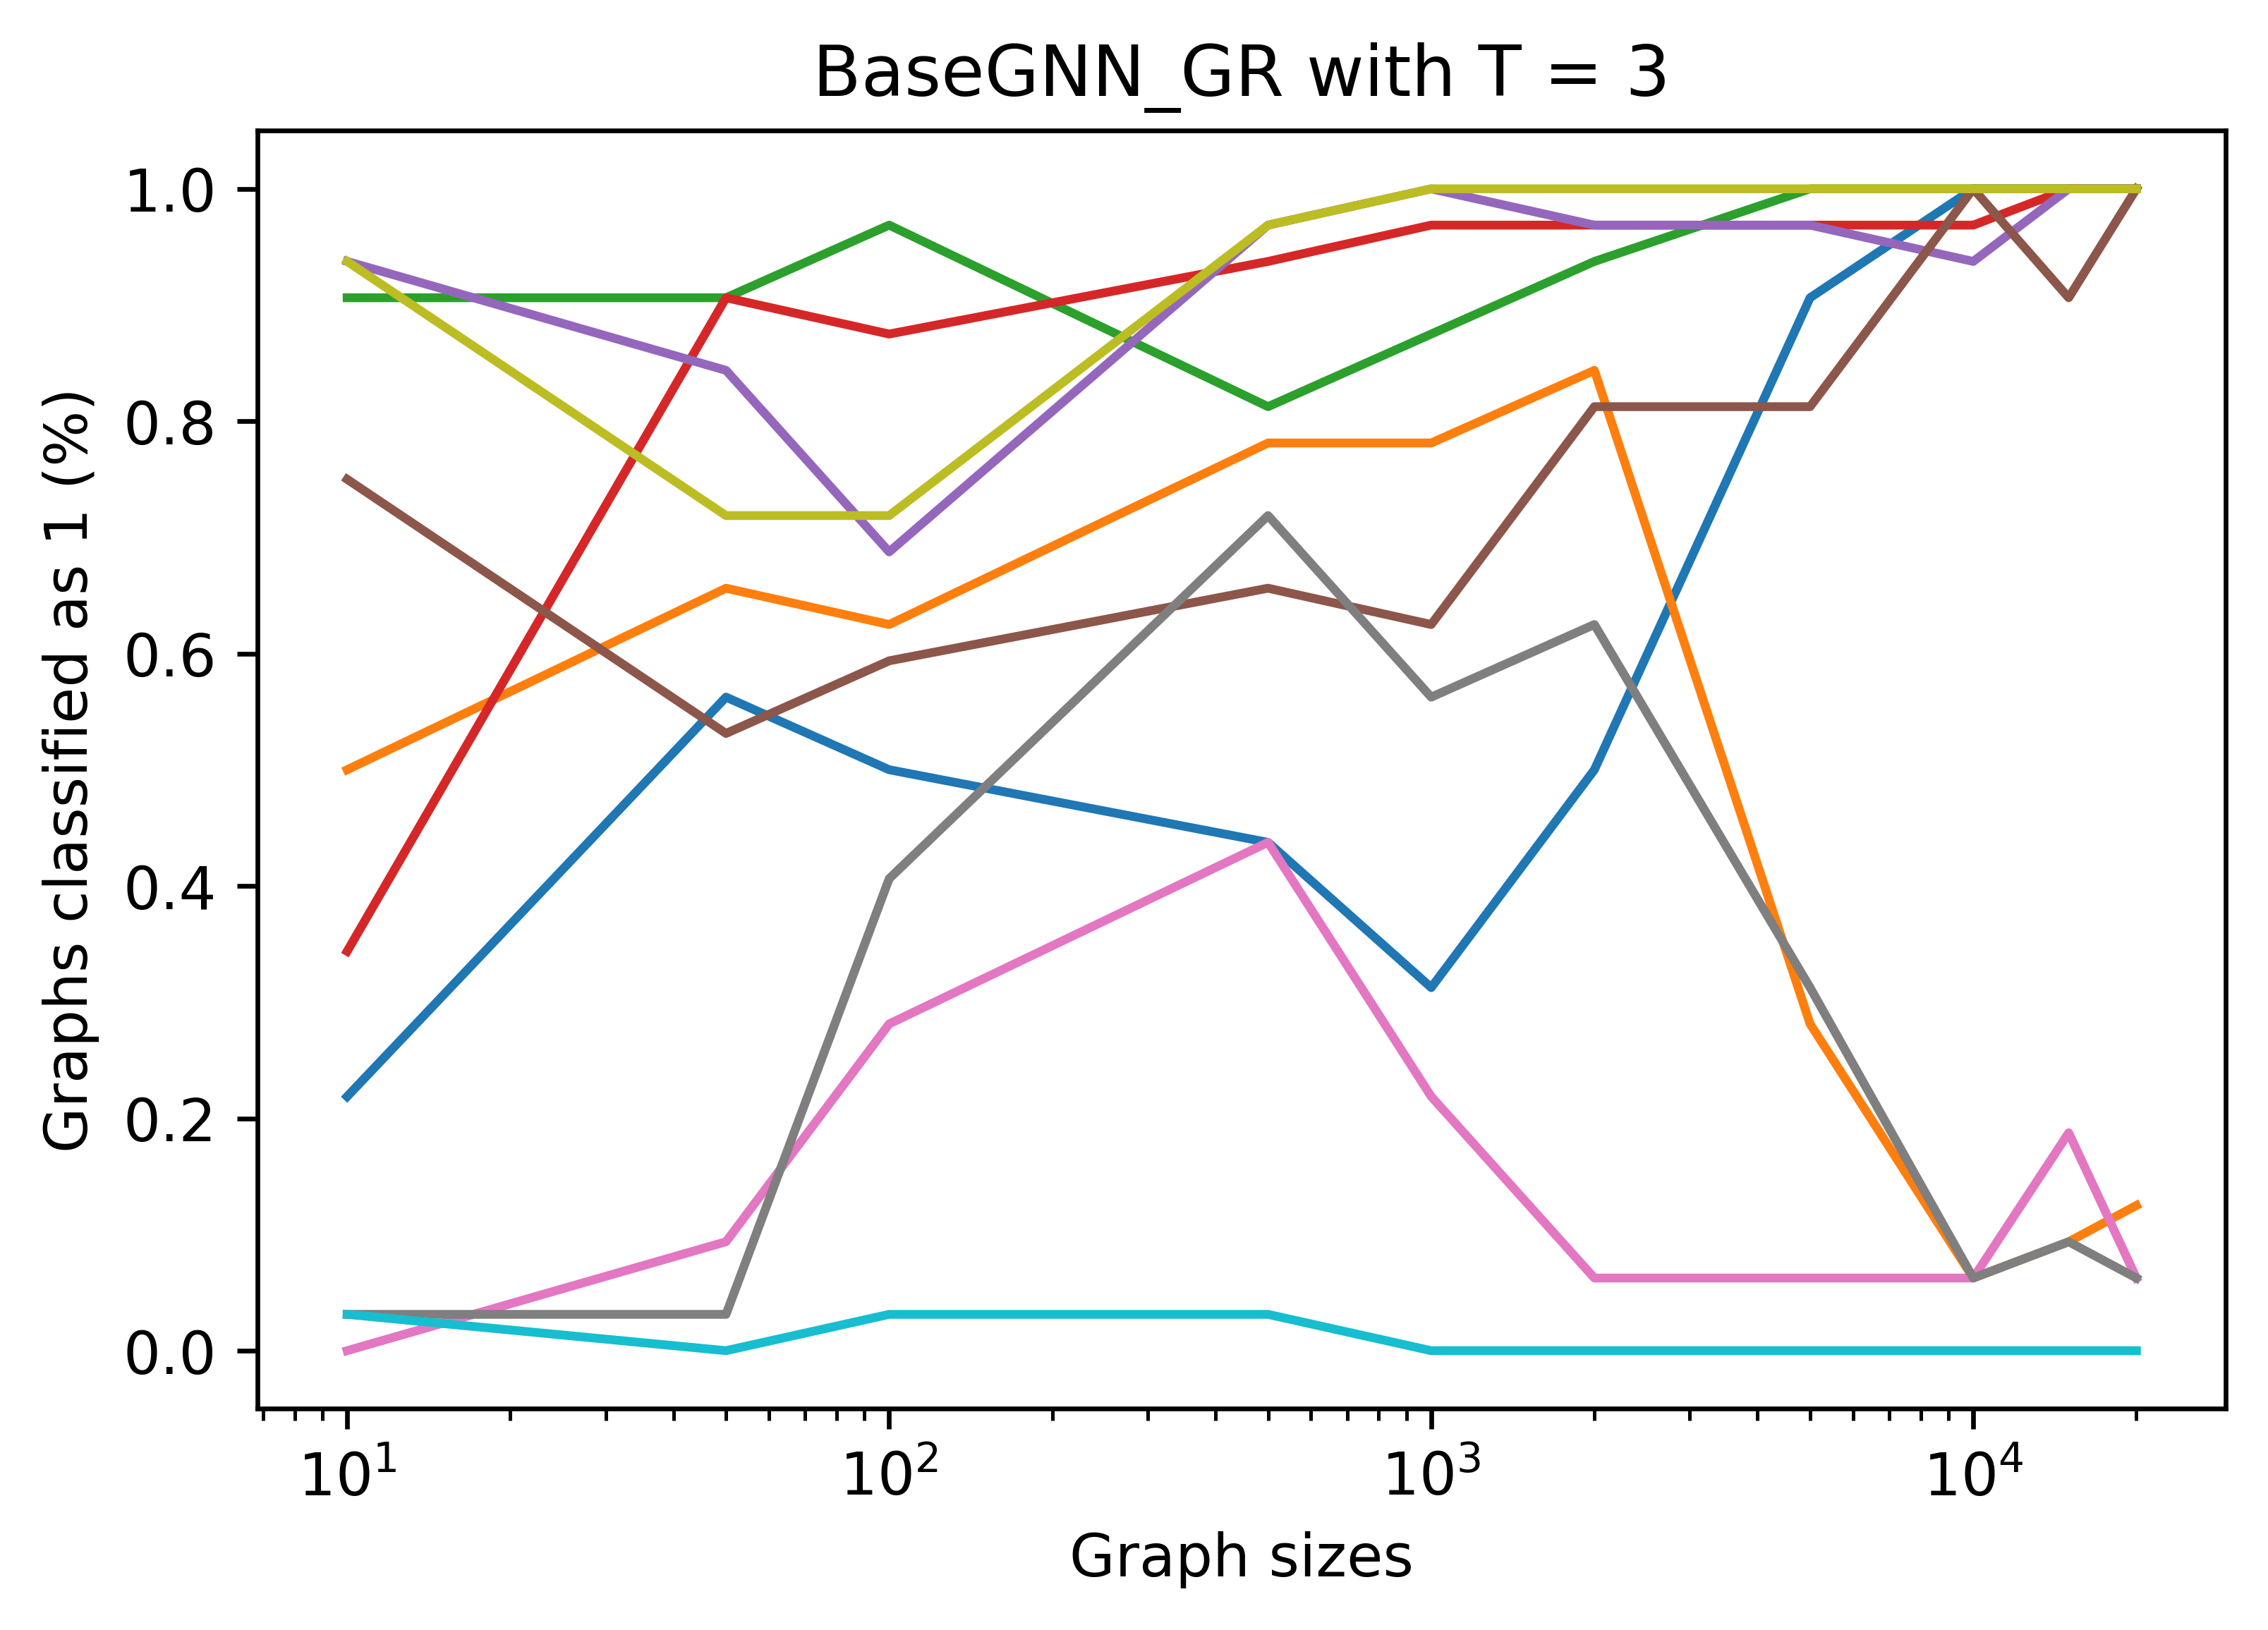

In [ ]:
for y in csv_numLayer_3:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'BaseGNN_GR with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/BaseGNN_GR with T = 3')
plt.show()

In [ ]:
import time
time.sleep(1000000)

KeyboardInterrupt: ignored

In [ ]:
csv = []

for d in [64]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                #base_gnn_gr = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         #num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                #mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            #num_layers=2, act_fn=torch.tanh)
                
                base_gnn_gr = torch.load(f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_gr_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                mlp = torch.load(f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")

                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                for graph_dim in [50000]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = base_gnn_gr(initial_node_feats, adj_matrix).mean(axis=0)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


[64, 0.5, 1, 0, [31]]
[64, 0.5, 1, 1, [0]]
[64, 0.5, 1, 2, [0]]
[64, 0.5, 1, 3, [0]]
[64, 0.5, 1, 4, [32]]
[64, 0.5, 1, 5, [32]]
[64, 0.5, 1, 6, [32]]
[64, 0.5, 1, 7, [0]]
[64, 0.5, 1, 8, [19]]
[64, 0.5, 1, 9, [32]]
[64, 0.5, 2, 0, [32]]
[64, 0.5, 2, 1, [4]]
[64, 0.5, 2, 2, [32]]
[64, 0.5, 2, 3, [0]]
[64, 0.5, 2, 4, [32]]
[64, 0.5, 2, 5, [0]]
[64, 0.5, 2, 6, [0]]
[64, 0.5, 2, 7, [32]]
[64, 0.5, 2, 8, [5]]
[64, 0.5, 2, 9, [32]]
[64, 0.5, 3, 0, [32]]
[64, 0.5, 3, 1, [0]]
[64, 0.5, 3, 2, [32]]
[64, 0.5, 3, 3, [32]]
[64, 0.5, 3, 4, [32]]
[64, 0.5, 3, 5, [32]]
[64, 0.5, 3, 6, [1]]
[64, 0.5, 3, 7, [0]]
[64, 0.5, 3, 8, [32]]
[64, 0.5, 3, 9, [0]]


In [ ]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_1.pickle"
with open(path_1, 'rb') as handle:
    csv_numLayer_1 = pickle.load(handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_2.pickle"
with open(path_2, 'rb') as handle:
    csv_numLayer_2 = pickle.load(handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/base_gnn_num_3.pickle"
with open(path_3, 'rb') as handle:
    csv_numLayer_3 = pickle.load(handle)

In [ ]:
print(csv_numLayer_1)

[[14, 2, 8, 12, 14, 19, 15, 23, 30, 29], [24, 2, 6, 4, 11, 2, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 11, 13, 25, 17, 2, 0, 0, 0, 0], [10, 31, 32, 32, 31, 27, 30, 32, 32, 32], [14, 19, 19, 29, 30, 31, 30, 31, 32, 32], [32, 32, 32, 32, 32, 32, 32, 32, 32, 32], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [9, 24, 24, 30, 27, 26, 26, 29, 23, 20], [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]


In [ ]:
print(csv_numLayer_2)

[[27, 7, 6, 25, 31, 32, 32, 32, 32, 32], [0, 3, 3, 8, 5, 10, 2, 10, 5, 3], [19, 14, 29, 28, 30, 24, 28, 32, 32, 32], [5, 3, 7, 2, 0, 2, 0, 0, 0, 0], [32, 30, 32, 32, 32, 32, 32, 32, 32, 32], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [24, 29, 25, 29, 27, 19, 6, 5, 1, 1], [15, 32, 32, 30, 24, 18, 4, 3, 0, 0], [13, 11, 9, 20, 20, 16, 22, 18, 9, 13], [9, 30, 26, 32, 32, 32, 32, 32, 32, 32]]


In [ ]:
print(csv_numLayer_3)

[[7, 18, 16, 14, 10, 16, 29, 32, 32, 32], [16, 21, 20, 25, 25, 27, 9, 2, 3, 4], [29, 29, 31, 26, 28, 30, 32, 32, 32, 32], [11, 29, 28, 30, 31, 31, 31, 31, 32, 32], [30, 27, 22, 31, 32, 31, 31, 30, 32, 32], [24, 17, 19, 21, 20, 26, 26, 32, 29, 32], [0, 3, 9, 14, 7, 2, 2, 2, 6, 2], [1, 1, 13, 23, 18, 20, 10, 2, 3, 2], [30, 23, 23, 31, 32, 32, 32, 32, 32, 32], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0]]


In [ ]:
ext_csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
ext_csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
ext_csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [ ]:
print(ext_csv_numLayer_1)
print(ext_csv_numLayer_2)
print(ext_csv_numLayer_3)

[[31], [0], [0], [0], [32], [32], [32], [0], [19], [32]]
[[32], [4], [32], [0], [32], [0], [0], [32], [5], [32]]
[[32], [0], [32], [32], [32], [32], [1], [0], [32], [0]]


In [ ]:
x = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 50000]

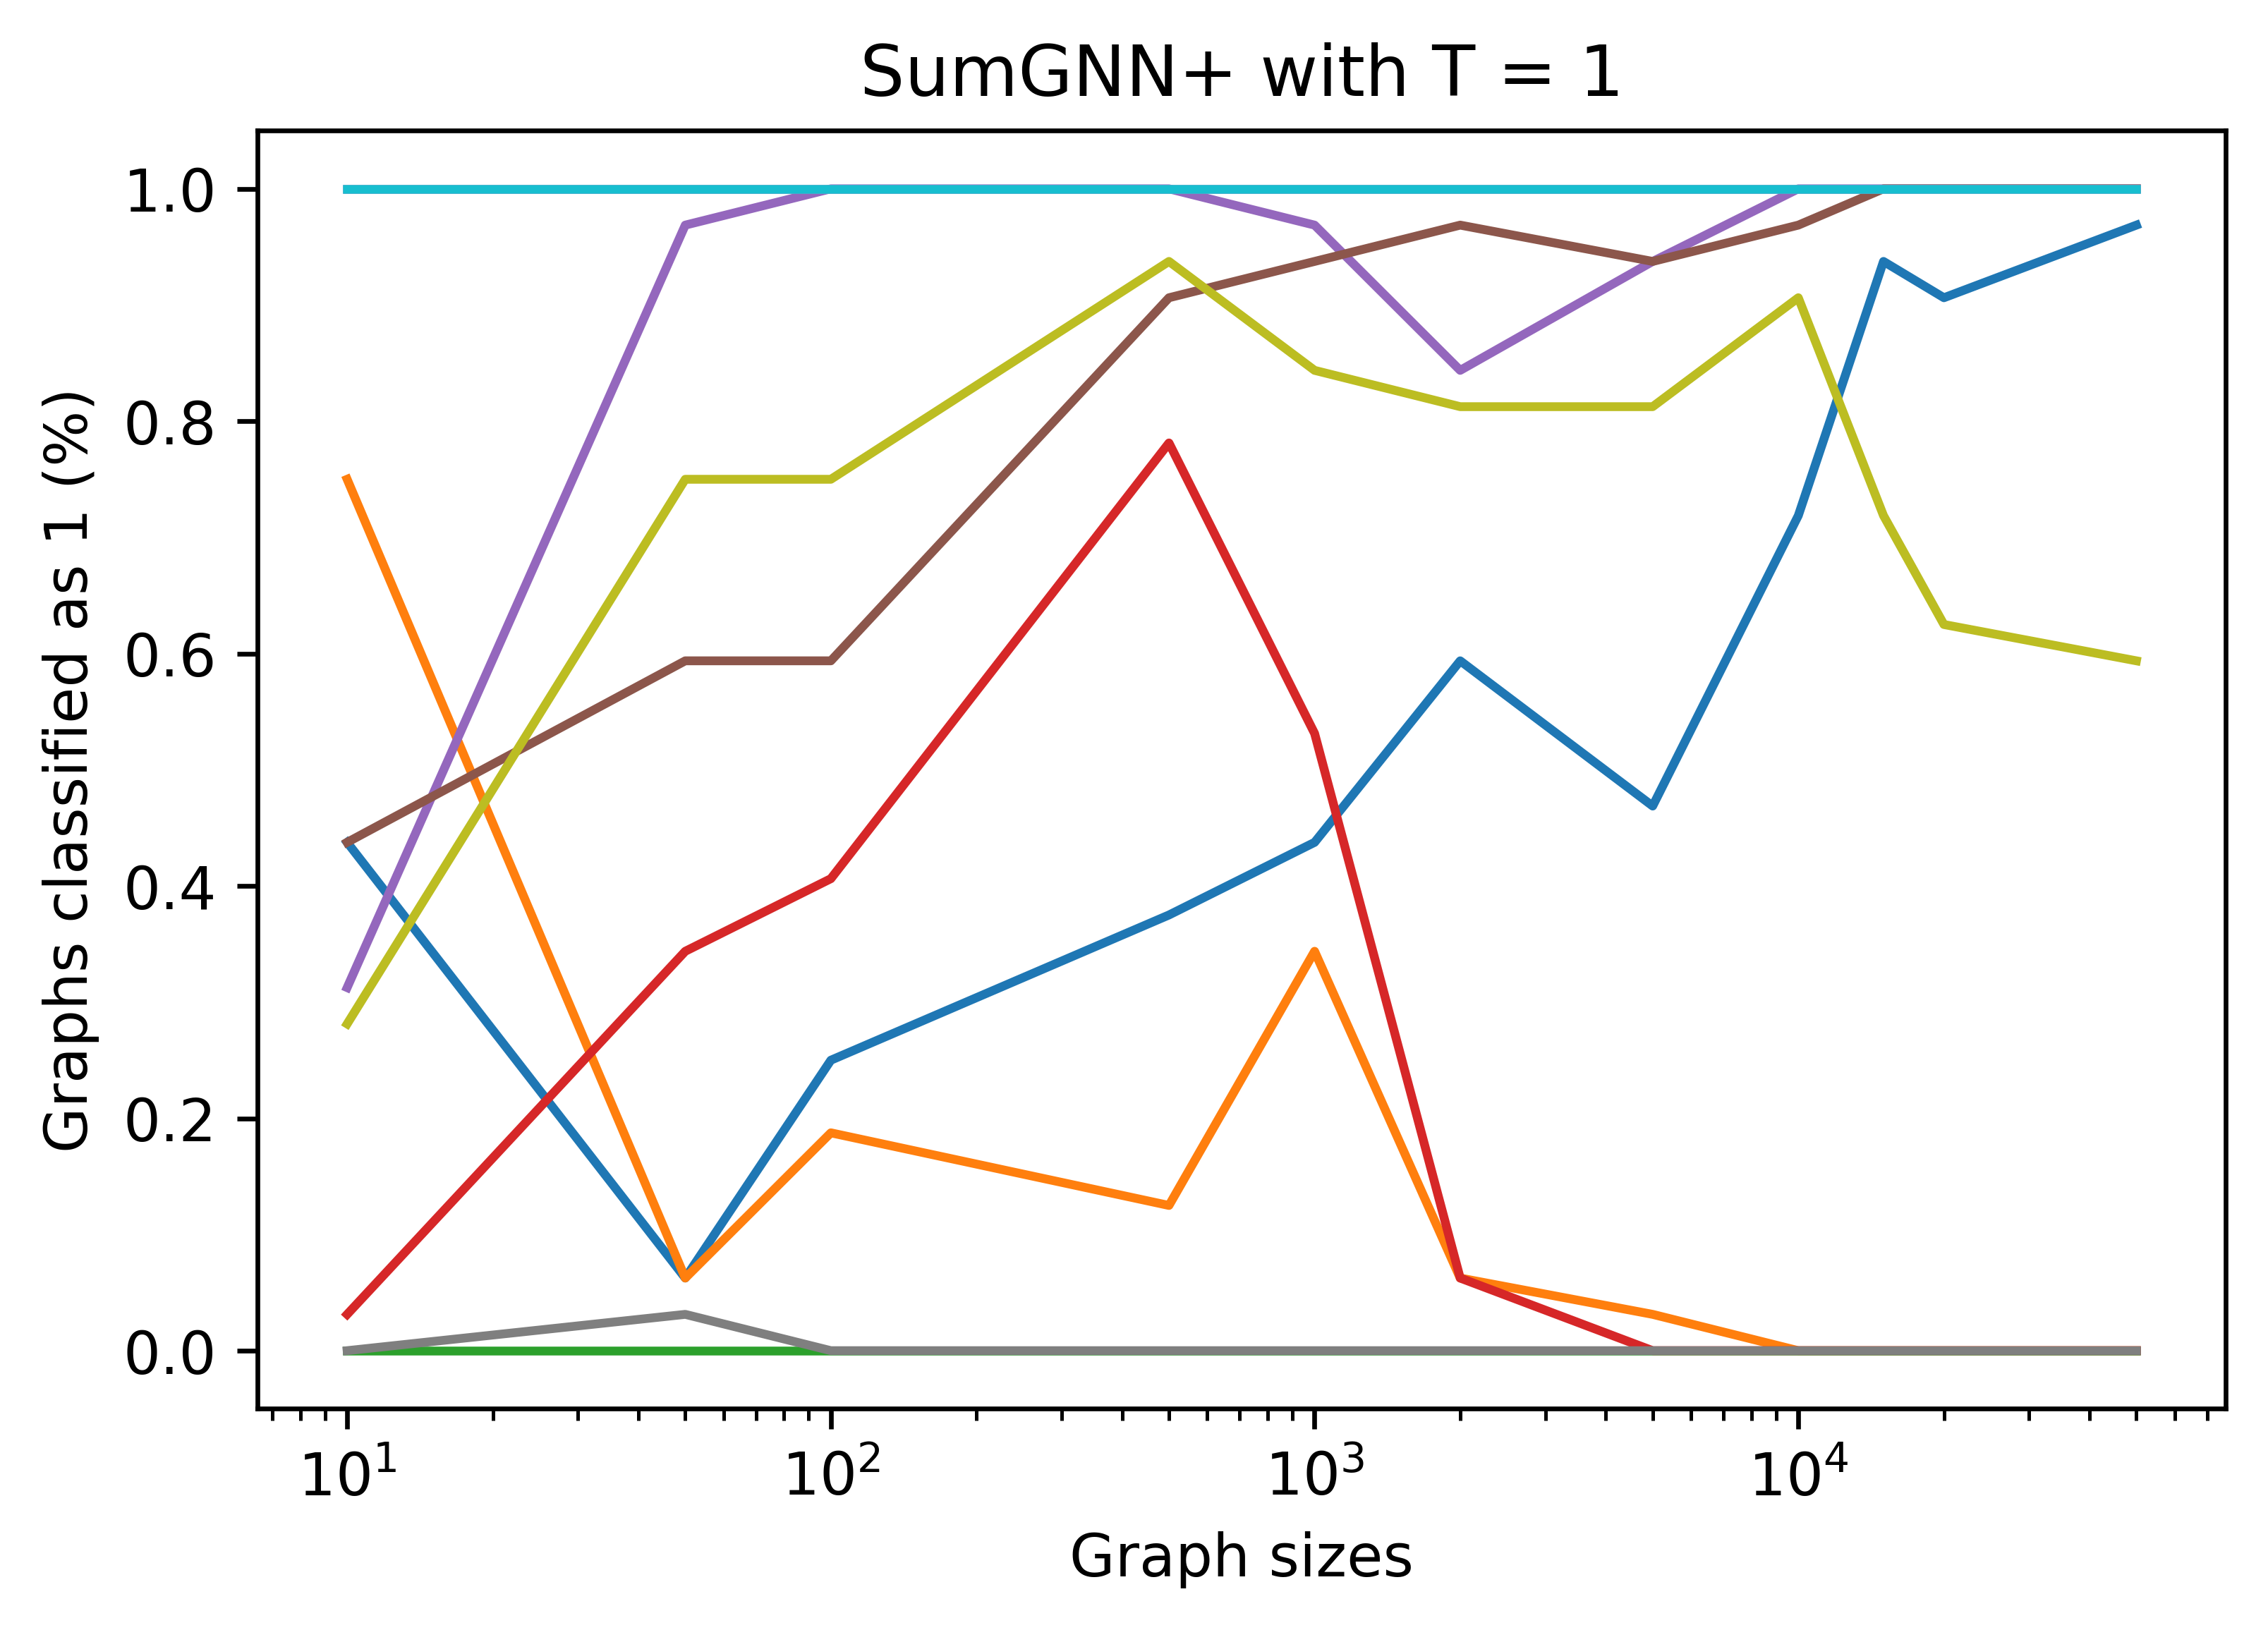

In [ ]:
for idx,y in enumerate(csv_numLayer_1):
  y = [item/32 for item in y] + [ext_csv_numLayer_1[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 1')
plt.show()

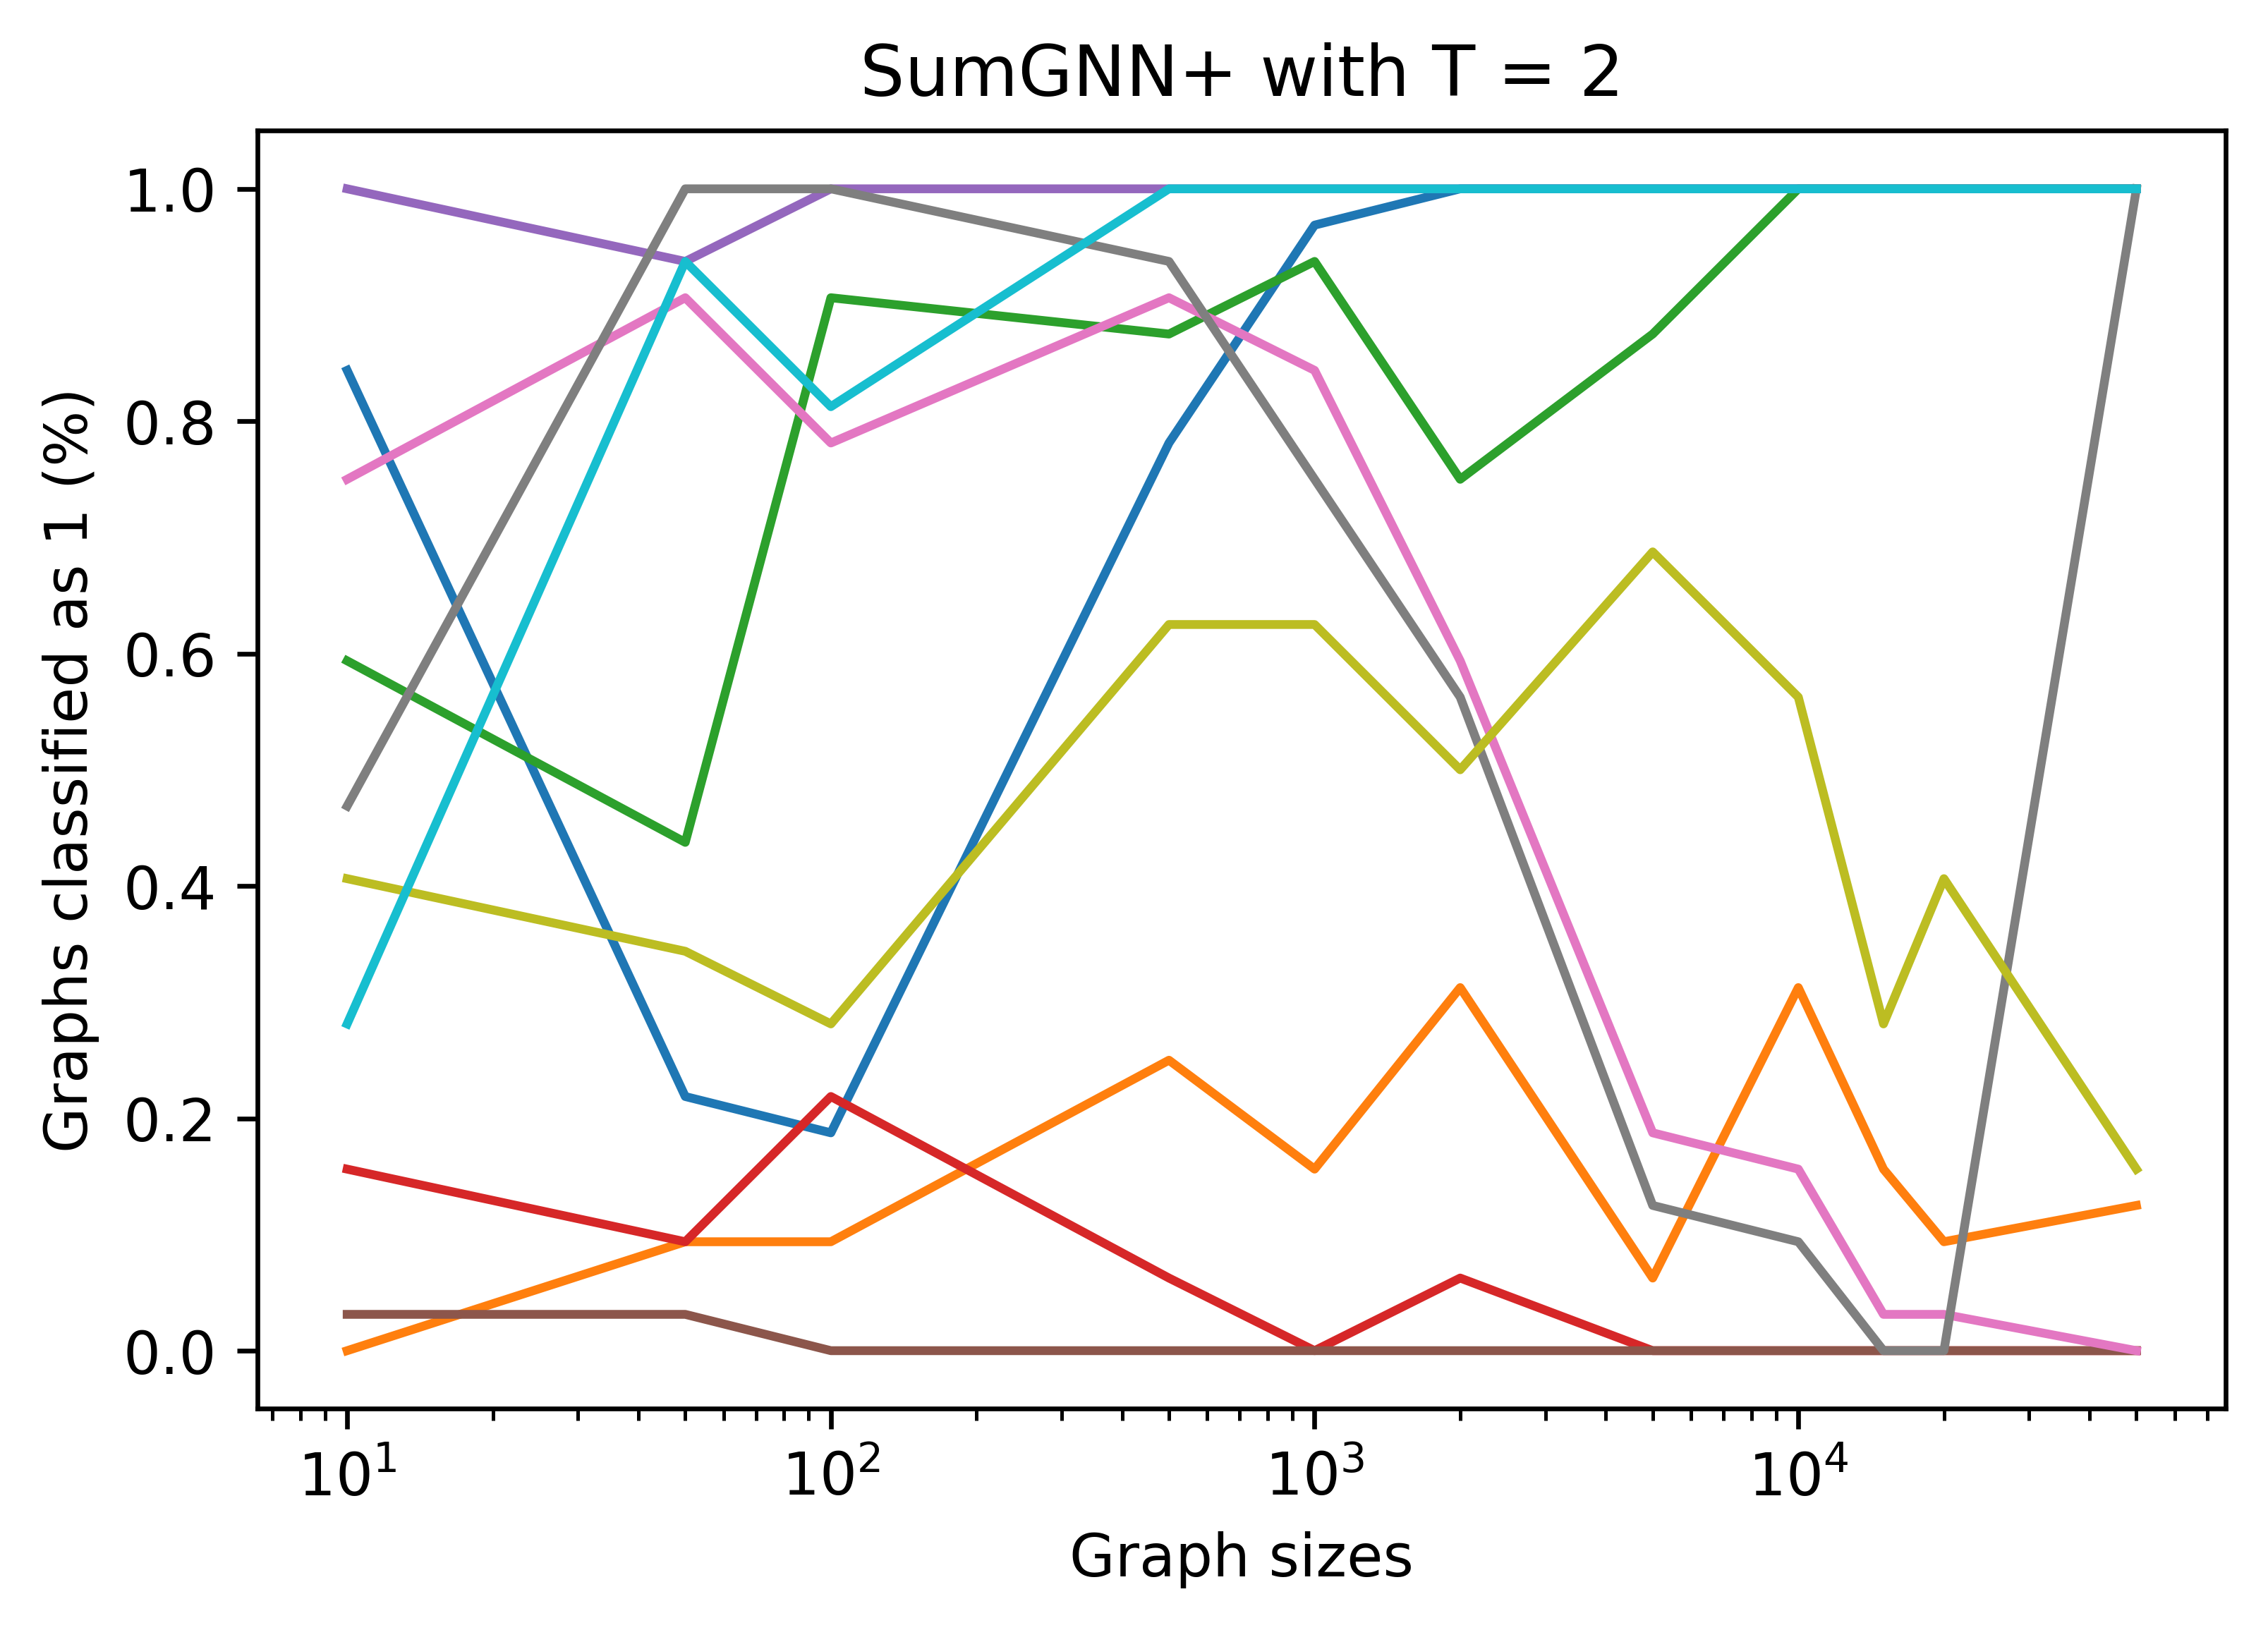

In [ ]:
for idx,y in enumerate(csv_numLayer_2):
  y = [item/32 for item in y] + [ext_csv_numLayer_2[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 2')
plt.show()

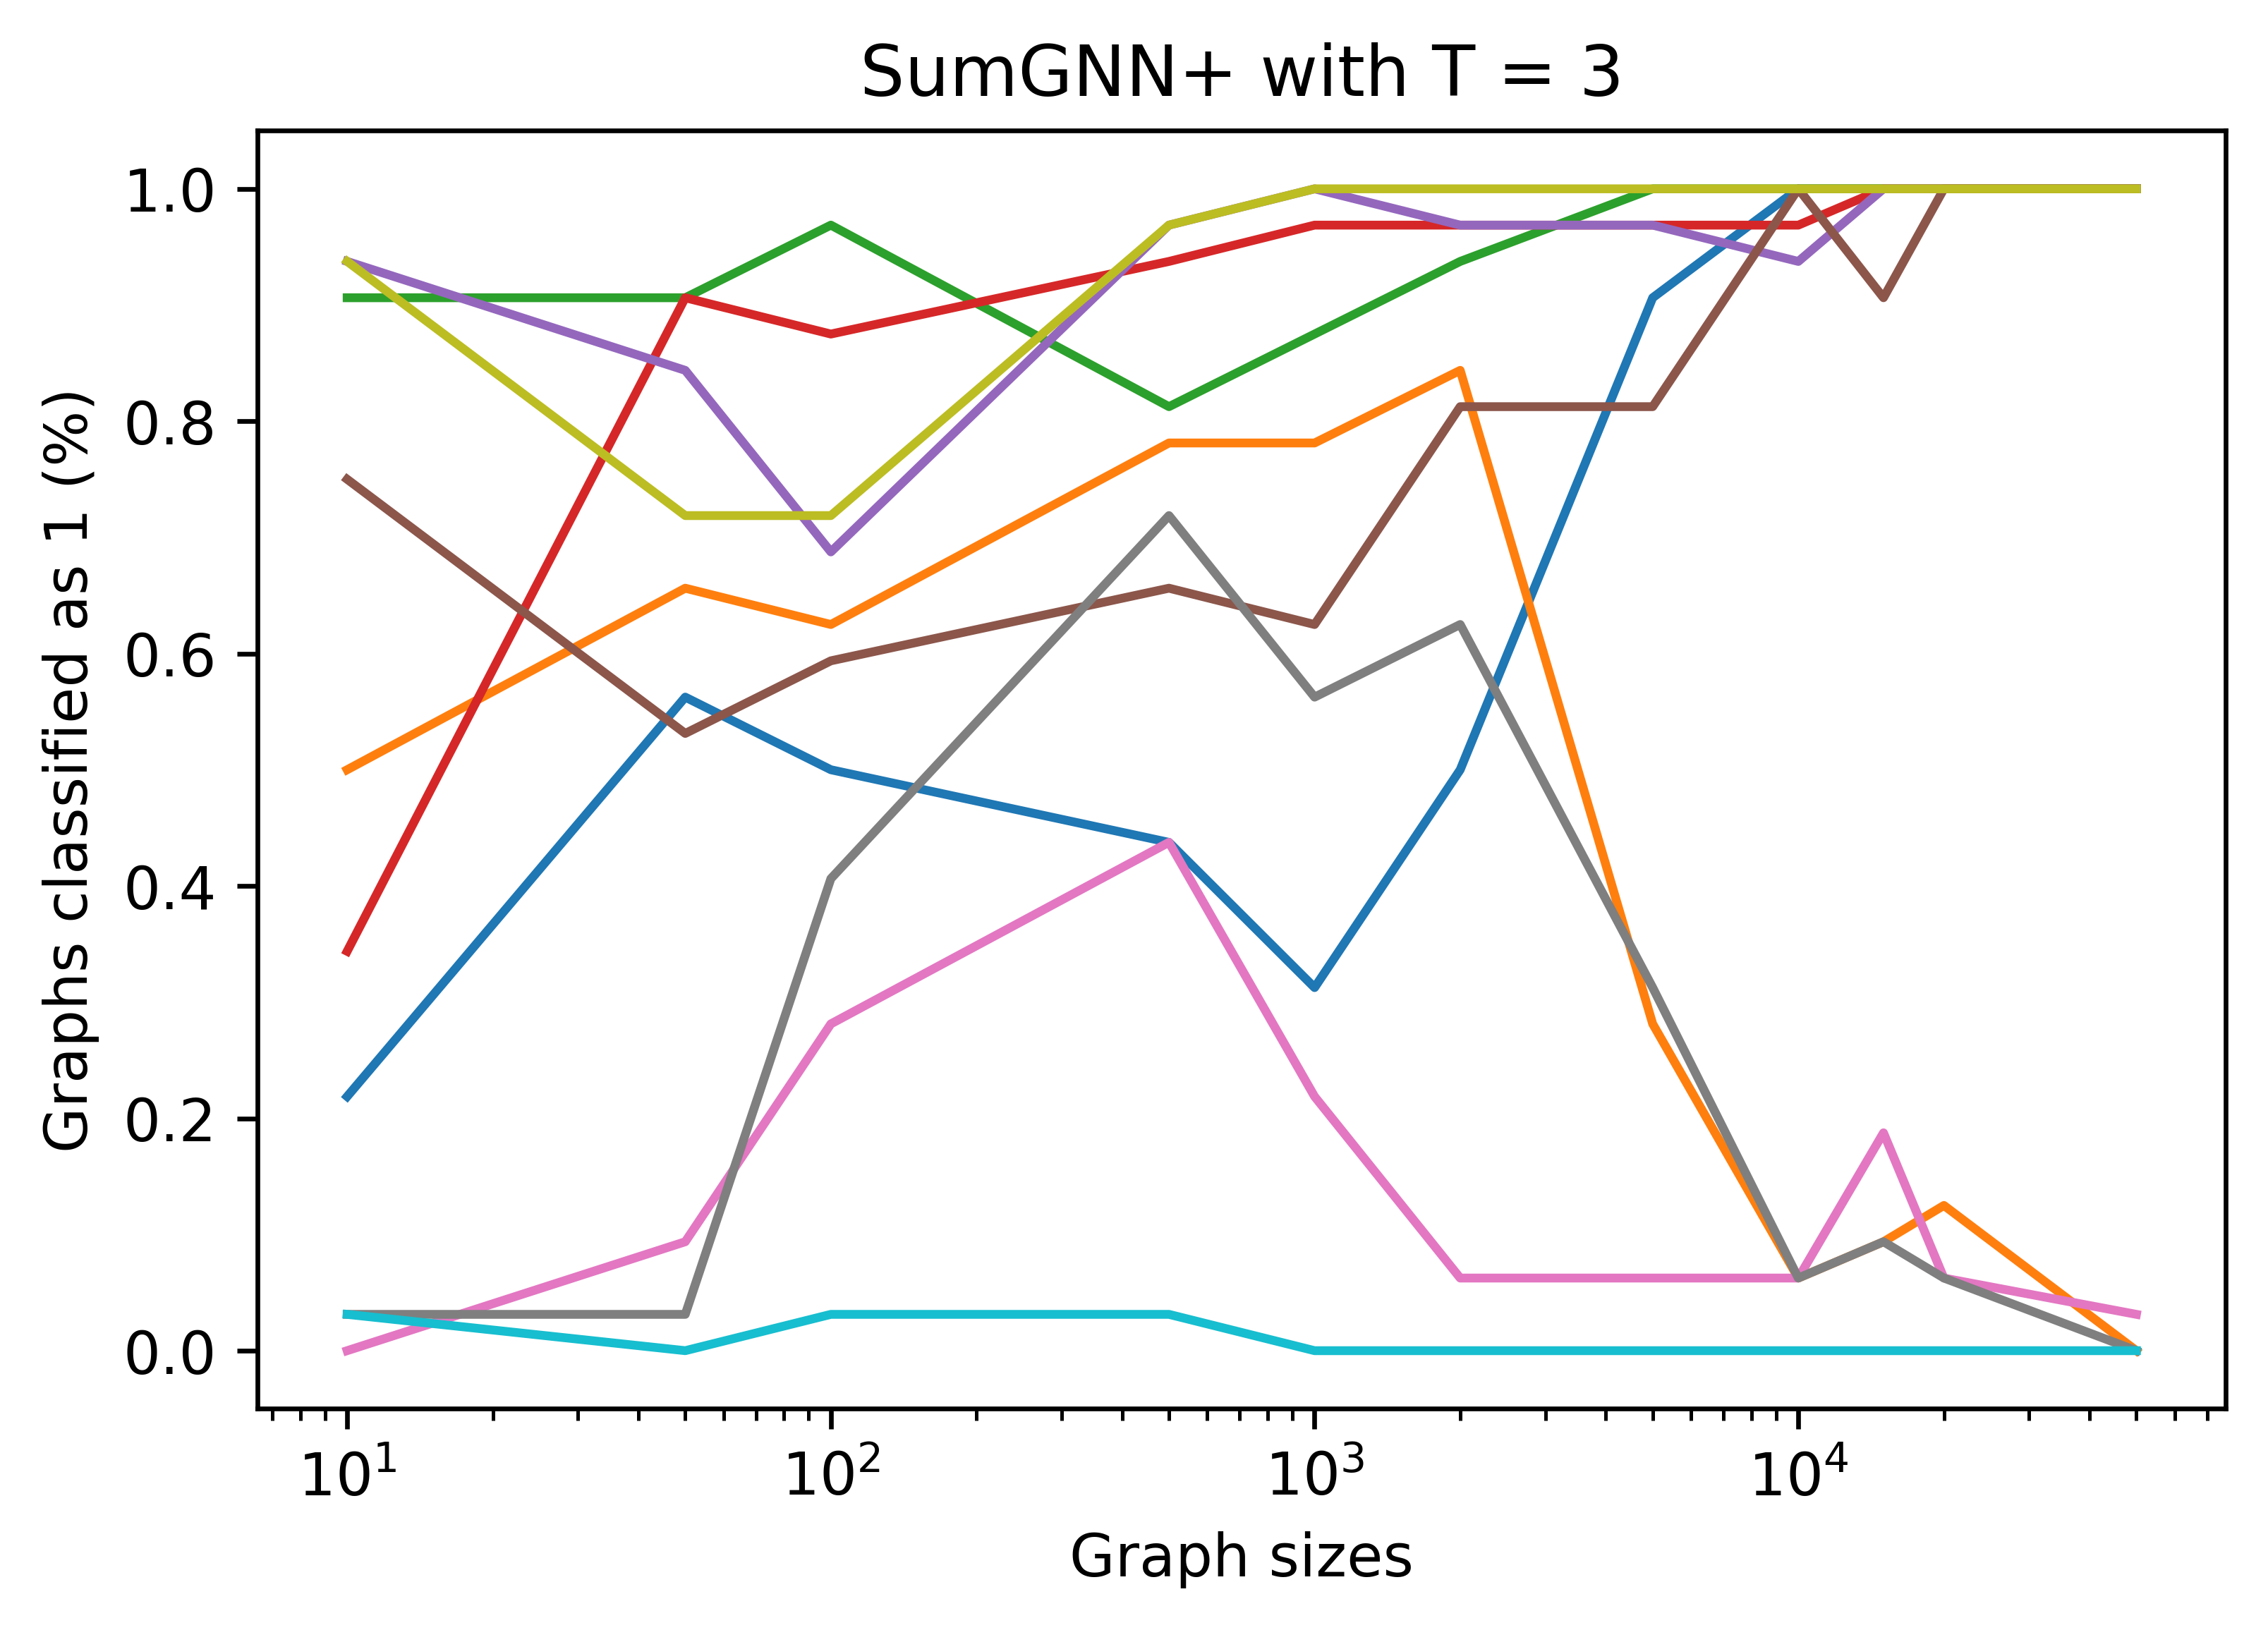

In [ ]:
for idx,y in enumerate(csv_numLayer_3):
  y = [item/32 for item in y] + [ext_csv_numLayer_3[idx][0]/32]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'SumGNN+ with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/partC/GNN0-1/BaseGNN_GR/Added_SumGNN+ with T = 3')
plt.show()

In [ ]:
import time
time.sleep(1000000)